## Model Development: Rule Based, IsolationForest, DBSCAN

In [1]:
import pandas as pd  
import os
import numpy as np  

%pwd

'c:\\Users\\user\\Desktop\\moniepoint\\notebooks'

In [2]:
os.chdir("../")

In [3]:
%pwd

'c:\\Users\\user\\Desktop\\moniepoint'

In [4]:
from features.feature_engineering import FeatureEngineer

In [5]:
from sklearn.ensemble import IsolationForest
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
import seaborn as sns  
import matplotlib.pyplot as plt  
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler


2025-08-15 23:27:06,168 - DEBUG - matplotlib data path: c:\Users\user\Desktop\moniepoint\.venv\Lib\site-packages\matplotlib\mpl-data
2025-08-15 23:27:06,173 - DEBUG - CONFIGDIR=C:\Users\user\.matplotlib
2025-08-15 23:27:06,206 - DEBUG - interactive is False
2025-08-15 23:27:06,206 - DEBUG - platform is win32
2025-08-15 23:27:06,382 - DEBUG - CACHEDIR=C:\Users\user\.matplotlib
2025-08-15 23:27:06,390 - DEBUG - Using fontManager instance from C:\Users\user\.matplotlib\fontlist-v390.json


In [6]:
from src.anomaly_detection.config.configuration import ConfigurationManager
from src.anomaly_detection.components.ingest_pipeline import DataIngestion
config = ConfigurationManager()
data_ingestion_config = config.get_data_ingestion_config()
df = DataIngestion(data_ingestion_config).get_data()
print(df.head())

C:\Users\user\Desktop\moniepoint


2025-08-15 23:27:07,173 - INFO - YAML file C:\Users\user\Desktop\moniepoint\config\config.yaml loaded successfully.
2025-08-15 23:27:07,173 - INFO - YAML file C:\Users\user\Desktop\moniepoint\params.yaml loaded successfully.
2025-08-15 23:27:07,190 - INFO - YAML file C:\Users\user\Desktop\moniepoint\schema.yaml loaded successfully.
2025-08-15 23:27:07,190 - INFO - Created directory at: artifacts
2025-08-15 23:27:07,200 - INFO - Created directory at: artifacts/data_ingestion
2025-08-15 23:27:07,491 - INFO - The file moniepoint\monie_point_data\synthetic_dirty_transaction_logs.csv loaded successfully with 7774 rows


   row_id                                       original_log  \
0       1  2025-07-05 19:18:10::user1069::withdrawal::299...   
1       2  usr:user1076|cashout|€4821.85|Glasgow|2025-07-...   
2       3  2025-07-20 05:38:14 >> [user1034] did top-up -...   
3       4  2025-06-13 10:04:51 >> [user1068] did deposit ...   
4       5  2025-07-29 23:47:37 | user: user1014 | txn: de...   

             datetime   user_id transaction_type   amount currency location  \
0 2025-07-05 19:18:10  user1069       withdrawal  2995.12      GBP   London   
1 2025-07-15 12:56:05  user1076          cashout  4821.85      EUR  Glasgow   
2 2025-07-20 05:38:14  user1034           top_up  2191.06      EUR  Unknown   
3 2025-06-13 10:04:51  user1068          deposit  1691.09      EUR  Glasgow   
4 2025-07-29 23:47:37  user1014          deposit  3539.50      GBP  Glasgow   

      device  
0  iPhone 13  
1    Pixel 6  
2  iPhone 13  
3    Unknown  
4  iPhone 13  


In [7]:
df.head()

row_id                                       original_log  \
0       1  2025-07-05 19:18:10::user1069::withdrawal::299...   
1       2  usr:user1076|cashout|€4821.85|Glasgow|2025-07-...   
2       3  2025-07-20 05:38:14 >> [user1034] did top-up -...   
3       4  2025-06-13 10:04:51 >> [user1068] did deposit ...   
4       5  2025-07-29 23:47:37 | user: user1014 | txn: de...   

             datetime   user_id transaction_type   amount currency location  \
0 2025-07-05 19:18:10  user1069       withdrawal  2995.12      GBP   London   
1 2025-07-15 12:56:05  user1076          cashout  4821.85      EUR  Glasgow   
2 2025-07-20 05:38:14  user1034           top_up  2191.06      EUR  Unknown   
3 2025-06-13 10:04:51  user1068          deposit  1691.09      EUR  Glasgow   
4 2025-07-29 23:47:37  user1014          deposit  3539.50      GBP  Glasgow   

      device  
0  iPhone 13  
1    Pixel 6  
2  iPhone 13  
3    Unknown  
4  iPhone 13

In [8]:
df = df.iloc[:, 2:]
print(df.head())

             datetime   user_id transaction_type   amount currency location  \
0 2025-07-05 19:18:10  user1069       withdrawal  2995.12      GBP   London   
1 2025-07-15 12:56:05  user1076          cashout  4821.85      EUR  Glasgow   
2 2025-07-20 05:38:14  user1034           top_up  2191.06      EUR  Unknown   
3 2025-06-13 10:04:51  user1068          deposit  1691.09      EUR  Glasgow   
4 2025-07-29 23:47:37  user1014          deposit  3539.50      GBP  Glasgow   

      device  
0  iPhone 13  
1    Pixel 6  
2  iPhone 13  
3    Unknown  
4  iPhone 13  


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7774 entries, 0 to 7773
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          7774 non-null   datetime64[ns]
 1   user_id           7774 non-null   object        
 2   transaction_type  7774 non-null   object        
 3   amount            7774 non-null   float64       
 4   currency          7774 non-null   object        
 5   location          7774 non-null   object        
 6   device            7774 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 425.3+ KB


In [10]:
df['device'].value_counts()

device
Xiaomi Mi 11          1140
Samsung Galaxy S10    1133
iPhone 13             1131
Nokia 3310            1108
Pixel 6               1101
Unknown               1081
Huawei P30            1080
Name: count, dtype: int64

In [11]:
df = FeatureEngineer(df).engineer_batch()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7774 entries, 0 to 7773
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   datetime                                 7774 non-null   datetime64[ns]
 1   user_id                                  7774 non-null   object        
 2   transaction_type                         7774 non-null   object        
 3   amount                                   7774 non-null   float64       
 4   currency                                 7774 non-null   object        
 5   location                                 7768 non-null   object        
 6   device                                   7758 non-null   object        
 7   day_of_week                              7774 non-null   int32         
 8   hour_of_day                              7774 non-null   int32         
 9   month                                    

In [13]:
print(df.shape)

(7774, 23)


In [14]:
df.head(30)

datetime   user_id transaction_type   amount currency  \
0  2025-06-01 12:03:31  user1000          cashout  2981.21      USD   
1  2025-06-01 19:19:50  user1000            debit  1267.67      EUR   
2  2025-06-02 19:52:44  user1000           refund  3610.68      USD   
3  2025-06-03 10:11:53  user1000          cashout  4659.06      GBP   
4  2025-06-03 21:23:30  user1000          cashout  4063.97      GBP   
5  2025-06-04 16:10:36  user1000           refund  2110.25      EUR   
6  2025-06-05 03:01:00  user1000          cashout  3032.41      GBP   
7  2025-06-05 11:30:55  user1000       withdrawal  3016.86      USD   
8  2025-06-07 07:27:00  user1000          deposit   353.96      GBP   
9  2025-06-09 22:30:55  user1000            debit   140.76      USD   
10 2025-06-10 07:08:58  user1000           top-up   536.81      GBP   
11 2025-06-10 18:10:07  user1000          cashout  4674.80      EUR   
12 2025-06-10 21:15:16  user1000         purchase   414.44      GBP   
13 2025-06-11 01:58:58  user1000          deposit  3443.90      GBP   
14 2025-06-11 17:23:13  user1000         purchase  3451.51      GBP   
15 2025-06-13 01:56:24  user1000           top-up  2676.48      GBP   
16 2025-06-14 21:24:18  user1000          cashout  3121.69      EUR   
17 2025-06-18 07:31:05  user1000          deposit  4537.72      EUR   
18 2025-06-20 02:01:24  user1000          deposit   320.17      GBP   
19 2025-06-20 14:42:40  user1000            debit  1775.60      EUR   
20 2025-06-21 11:15:04  user1000           top_up  4737.85      EUR   
21 2025-06-22 03:57:41  user1000       withdrawal  1798.45      USD   
22 2025-06-22 12:54:09  user1000           top-up  3363.80      GBP   
23 2025-06-22 13:10:57  user1000            debit  2182.71      GBP   
24 2025-06-22 14:05:49  user1000           top-up   507.91      GBP   
25 2025-06-22 16:54:22  user1000         transfer  3273.93      GBP   
26 2025-06-23 22:51:43  user1000            debit   940.66      GBP   
27 2025-06-24 07:07:01  user1000           top-up  4299.36      EUR   
28 2025-06-25 00:24:08  user1000           top-up  4696.81      EUR   
29 2025-06-25 10:12:11  user1000           top-up   935.32      GBP   

      location              device  day_of_week  hour_of_day  month  ...  \
0       London  Samsung Galaxy S10            6           12      6  ...   
1   Manchester        Xiaomi Mi 11            6           19      6  ...   
2      Cardiff          Huawei P30            0           19      6  ...   
3   Birmingham          Nokia 3310            1           10      6  ...   
4    Liverpool          Nokia 3310            1           21      6  ...   
5   Birmingham  Samsung Galaxy S10            2           16      6  ...   
6        Leeds             Pixel 6            3            3      6  ...   
7        Leeds           iPhone 13            3           11      6  ...   
8        Leeds             Pixel 6            5            7      6  ...   
9   Manchester             Pixel 6            0           22      6  ...   
10       Leeds           iPhone 13            1            7      6  ...   
11       Leeds  Samsung Galaxy S10            1           18      6  ...   
12       Leeds  Samsung Galaxy S10            1           21      6  ...   
13   Liverpool             Pixel 6            2            1      6  ...   
14  Birmingham        Xiaomi Mi 11            2           17      6  ...   
15     Glasgow        Xiaomi Mi 11            4            1      6  ...   
16  Birmingham          Huawei P30            5           21      6  ...   
17     Cardiff          Huawei P30            2            7      6  ...   
18      London             Pixel 6            4            2      6  ...   
19  Birmingham             Pixel 6            4           14      6  ...   
20   Liverpool             Pixel 6            5           11      6  ...   
21  Manchester          Huawei P30            6            3      6  ...   
22       Leeds          Huawei P30            6           12    

In [15]:
print(df[["datetime",'device']].head())

             datetime              device
0 2025-06-01 12:03:31  Samsung Galaxy S10
1 2025-06-01 19:19:50        Xiaomi Mi 11
2 2025-06-02 19:52:44          Huawei P30
3 2025-06-03 10:11:53          Nokia 3310
4 2025-06-03 21:23:30          Nokia 3310


In [16]:
%pwd

'c:\\Users\\user\\Desktop\\moniepoint'

In [17]:
from src.anomaly_detection.utils.common import convert_to_usd

df = convert_to_usd(df)
df.head()

datetime   user_id transaction_type     amount currency  \
0 2025-06-01 12:03:31  user1000          cashout  2981.2100      USD   
1 2025-06-01 19:19:50  user1000            debit  1394.4370      EUR   
2 2025-06-02 19:52:44  user1000           refund  3610.6800      USD   
3 2025-06-03 10:11:53  user1000          cashout  5823.8250      GBP   
4 2025-06-03 21:23:30  user1000          cashout  5079.9625      GBP   

     location              device  day_of_week  hour_of_day  month  ...  \
0      London  Samsung Galaxy S10            6           12      6  ...   
1  Manchester        Xiaomi Mi 11            6           19      6  ...   
2     Cardiff          Huawei P30            0           19      6  ...   
3  Birmingham          Nokia 3310            1           10      6  ...   
4   Liverpool          Nokia 3310            1           21      6  ...   

   is_business_hours  transaction_count_last_7_days  \
0               True                            1.0   
1              False                            2.0   
2              False                            3.0   
3               True                            4.0   
4              False                            5.0   

   average_transaction_amount_last_10_days  days_since_last_transaction  \
0                              2981.210000                          0.0   
1                              2124.440000                          0.0   
2                              2619.853333                          1.0   
3                              3129.655000                          0.0   
4                              3316.518000                          0.0   

   unique_locations_used  new_device  amount_z_score_user  \
0                      1           1             0.328784   
1                      2           1            -0.814357   
2                      3           1             0.748718   
3                      4           1             1.448116   
4                      5           0             1.051118   

   hours_since_last_transaction_user  transaction_count_today_user  \
0                           0.000000                             2   
1                           7.271944                             2   
2                          24.548333                             1   
3                          14.319167                             2   
4                          11.193611                             2   

   amount_percentile_user  
0                0.581081  
1                0.297297  
2                0.743243  
3                0.905405  
4                0.770270  

[5 rows x 23 columns]

In [18]:
df.columns

Index(['datetime', 'user_id', 'transaction_type', 'amount', 'currency',
       'location', 'device', 'day_of_week', 'hour_of_day', 'month', 'quarter',
       'is_weekend', 'day_of_month', 'is_business_hours',
       'transaction_count_last_7_days',
       'average_transaction_amount_last_10_days',
       'days_since_last_transaction', 'unique_locations_used', 'new_device',
       'amount_z_score_user', 'hours_since_last_transaction_user',
       'transaction_count_today_user', 'amount_percentile_user'],
      dtype='object')

In [19]:
df['is_business_hours'] = df['is_business_hours'].astype(float)
df['is_weekend'] = df['is_weekend'].astype(float)

2025-08-15 23:27:09,074 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-15 23:27:09,077 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-15 23:27:09,089 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-08-15 23:27:09,091 - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\user\\Desktop\\moniepoint\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-08-15 23:27:09,093 - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\user\\Desktop\\moniepoint\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-08-15 23:27:09,095 - DEBUG - findfont: score(FontEntry

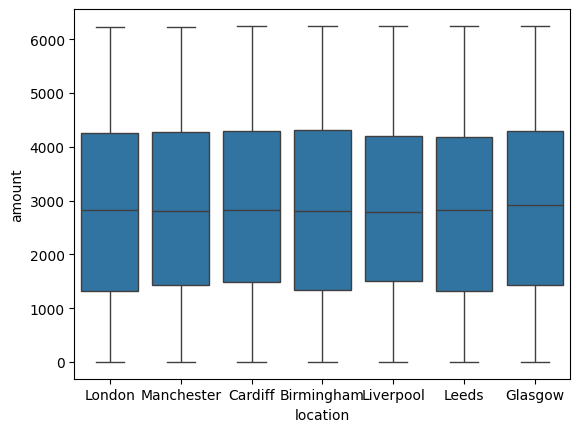

In [20]:
sns.boxplot(data=df, x=df['location'], y = df['amount'])
plt.show()

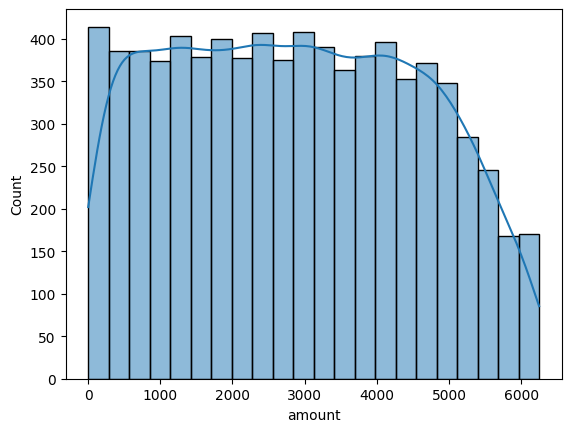

In [21]:
sns.histplot(data=df, x="amount", kde=True)
plt.show()

In [22]:
df.head()

datetime   user_id transaction_type     amount currency  \
0 2025-06-01 12:03:31  user1000          cashout  2981.2100      USD   
1 2025-06-01 19:19:50  user1000            debit  1394.4370      EUR   
2 2025-06-02 19:52:44  user1000           refund  3610.6800      USD   
3 2025-06-03 10:11:53  user1000          cashout  5823.8250      GBP   
4 2025-06-03 21:23:30  user1000          cashout  5079.9625      GBP   

     location              device  day_of_week  hour_of_day  month  ...  \
0      London  Samsung Galaxy S10            6           12      6  ...   
1  Manchester        Xiaomi Mi 11            6           19      6  ...   
2     Cardiff          Huawei P30            0           19      6  ...   
3  Birmingham          Nokia 3310            1           10      6  ...   
4   Liverpool          Nokia 3310            1           21      6  ...   

   is_business_hours  transaction_count_last_7_days  \
0                1.0                            1.0   
1                0.0                            2.0   
2                0.0                            3.0   
3                1.0                            4.0   
4                0.0                            5.0   

   average_transaction_amount_last_10_days  days_since_last_transaction  \
0                              2981.210000                          0.0   
1                              2124.440000                          0.0   
2                              2619.853333                          1.0   
3                              3129.655000                          0.0   
4                              3316.518000                          0.0   

   unique_locations_used  new_device  amount_z_score_user  \
0                      1           1             0.328784   
1                      2           1            -0.814357   
2                      3           1             0.748718   
3                      4           1             1.448116   
4                      5           0             1.051118   

   hours_since_last_transaction_user  transaction_count_today_user  \
0                           0.000000                             2   
1                           7.271944                             2   
2                          24.548333                             1   
3                          14.319167                             2   
4                          11.193611                             2   

   amount_percentile_user  
0                0.581081  
1                0.297297  
2                0.743243  
3                0.905405  
4                0.770270  

[5 rows x 23 columns]

In [23]:
df['location'].nunique()

7

In [24]:
df['transaction_type'].nunique()

9

In [25]:
df['device'].nunique()

6

In [26]:
from src.anomaly_detection.utils.common import label_encode_columns

In [27]:
columns = ["device", "transaction_type", "location"]

df_encoded, fitted_encoders = label_encode_columns(df, columns)

print("Encoded DataFrame:\n", df_encoded)
print("\nLabel Encoders:", fitted_encoders)

Encoded DataFrame:
                 datetime   user_id  transaction_type     amount currency  \
0    2025-06-01 12:03:31  user1000                 0  2981.2100      USD   
1    2025-06-01 19:19:50  user1000                 1  1394.4370      EUR   
2    2025-06-02 19:52:44  user1000                 4  3610.6800      USD   
3    2025-06-03 10:11:53  user1000                 0  5823.8250      GBP   
4    2025-06-03 21:23:30  user1000                 0  5079.9625      GBP   
...                  ...       ...               ...        ...      ...   
7769 2025-07-24 14:45:45  user1099                 4  1775.4500      GBP   
7770 2025-07-25 10:04:10  user1099                 1  3132.6240      EUR   
7771 2025-07-25 18:10:43  user1099                 4  3595.1375      GBP   
7772 2025-07-27 11:55:14  user1099                 1  1429.5050      EUR   
7773 2025-07-29 10:46:11  user1099                 7  3915.4830      EUR   

      location  device  day_of_week  hour_of_day  month  ...  \
0  

In [ ]:
from sklearn.ensemble import IsolationForest

features = ['device', 'transaction_type', 'location', 'amount', 
       'day_of_week', 'hour_of_day', 'month', 'quarter',
       'is_weekend', 'day_of_month', 'is_business_hours',
       'transaction_count_last_7_days',
       'average_transaction_amount_last_10_days',
       'days_since_last_transaction', 'unique_locations_used', 'new_device',
       'amount_z_score_user', 'hours_since_last_transaction_user',
       'transaction_count_today_user', 'amount_percentile_user']

print(len(features))

X = df_encoded[features].copy()

# Train Isolation Forest
model = IsolationForest(
    n_estimators=150,
    max_samples=0.8,
    contamination=0.03,
    random_state=42,
    verbose=True
)
model.fit(X)

20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


IsolationForest(contamination=0.05, n_estimators=150, random_state=42,
                verbose=True)

In [29]:
# Store anomaly score and label in the main dataframe
df_encoded["anomaly_score"] = model.decision_function(X)
df_encoded["anomaly_label"] = model.predict(X)

print(df_encoded[["anomaly_score", "anomaly_label"]].head())

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


   anomaly_score  anomaly_label
0      -0.023431             -1
1      -0.011372             -1
2      -0.005778             -1
3      -0.001562             -1
4       0.065695              1


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


In [30]:
df_encoded['anomaly_label'] = np.where(df_encoded['anomaly_label']== -1, 1, 0)

In [31]:
len(df_encoded[df_encoded['anomaly_label'] == 1])

389

In [32]:
len(df_encoded[df_encoded['anomaly_label'] == 0])

7385

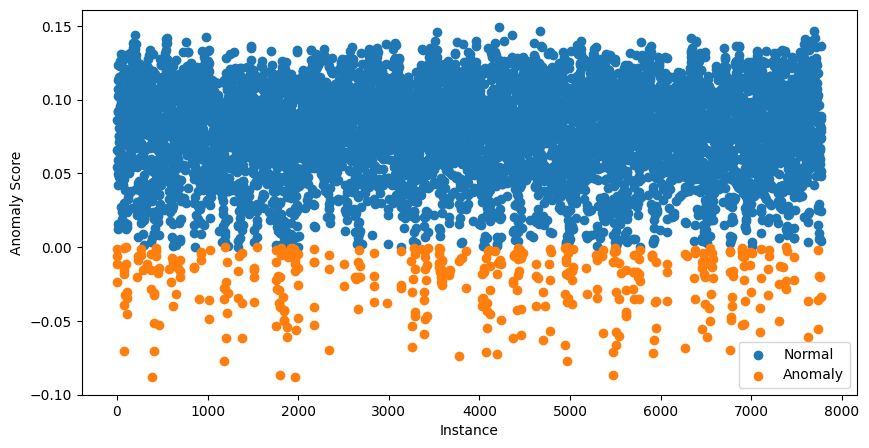

In [33]:
# Visualization of the results
plt.figure(figsize=(10, 5))

# Plot normal instances
normal = df_encoded[df_encoded['anomaly_label'] == 0]
plt.scatter(normal.index, normal['anomaly_score'], label='Normal')

# Plot anomalies
anomalies = df_encoded[df_encoded['anomaly_label'] == 1]
plt.scatter(anomalies.index, anomalies['anomaly_score'], label='Anomaly')
plt.xlabel("Instance")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

In [34]:
normal.head(3)

datetime   user_id  transaction_type     amount currency  \
4 2025-06-03 21:23:30  user1000                 0  5079.9625      GBP   
5 2025-06-04 16:10:36  user1000                 4  2321.2750      EUR   
6 2025-06-05 03:01:00  user1000                 0  3790.5125      GBP   

   location  device  day_of_week  hour_of_day  month  ...  \
4         4       1            1           21      6  ...   
5         0       3            2           16      6  ...   
6         3       2            3            3      6  ...   

   average_transaction_amount_last_10_days  days_since_last_transaction  \
4                              3316.518000                          0.0   
5                              3115.473333                          0.0   
6                              3103.607143                          0.0   

   unique_locations_used  new_device  amount_z_score_user  \
4                      5           0             1.051118   
5                      5           0            -0.252253   
6                      6           1             0.362941   

   hours_since_last_transaction_user  transaction_count_today_user  \
4                          11.193611                             2   
5                          18.785000                             1   
6                          10.840000                             2   

   amount_percentile_user  anomaly_score  anomaly_label  
4                0.770270       0.065695              0  
5                0.445946       0.086315              0  
6                0.621622       0.054319              0  

[3 rows x 25 columns]

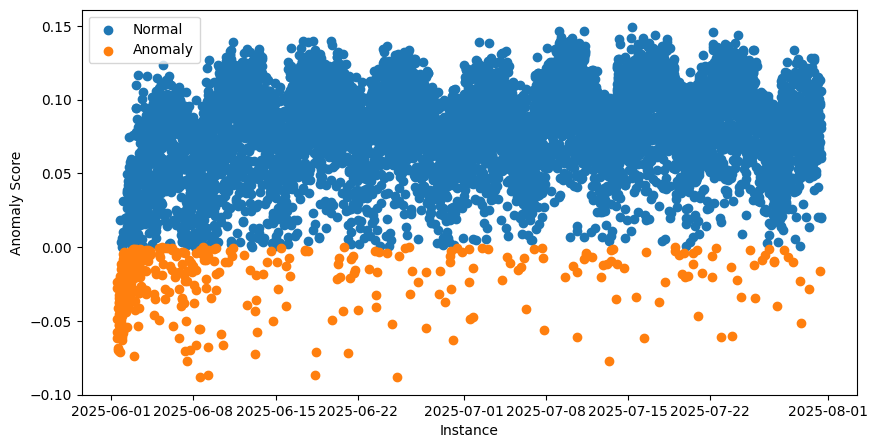

In [35]:
# Visualization of the results
plt.figure(figsize=(10, 5))

# Plot normal instances
normal = df_encoded[df_encoded['anomaly_label'] == 0]
plt.scatter(normal['datetime'], normal['anomaly_score'], label='Normal')

# Plot anomalies
anomalies = df_encoded[df_encoded['anomaly_label'] == 1]
plt.scatter(anomalies['datetime'], anomalies['anomaly_score'], label='Anomaly')

plt.xlabel("Instance")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

#### Further Analysis

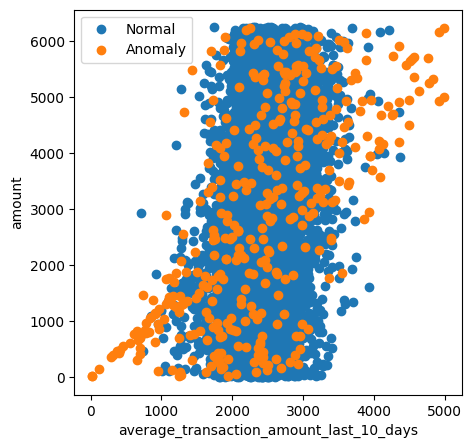

In [36]:
# Visualization of the results
plt.figure(figsize=(5, 5))

# Plot non-anomalies then anomalies
plt.scatter(normal['average_transaction_amount_last_10_days'], normal['amount'], label='Normal')
plt.scatter(anomalies['average_transaction_amount_last_10_days'], anomalies['amount'], label='Anomaly')
plt.xlabel("average_transaction_amount_last_10_days")
plt.ylabel("amount")
plt.legend()
plt.show()

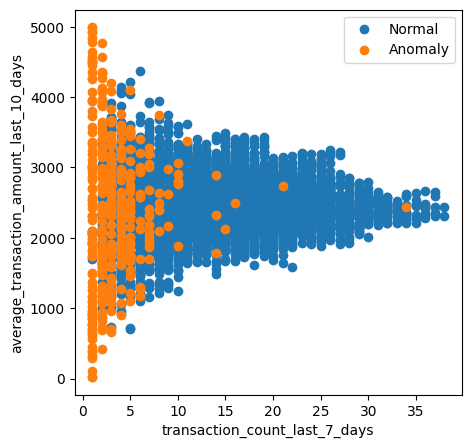

In [37]:
# Visualization of the results
plt.figure(figsize=(5, 5))

# Plot non-anomalies then anomalies
plt.scatter(y=normal['average_transaction_amount_last_10_days'], x=normal['transaction_count_last_7_days'], label='Normal')
plt.scatter(y=anomalies['average_transaction_amount_last_10_days'], x=anomalies['transaction_count_last_7_days'], label='Anomaly')
plt.ylabel("average_transaction_amount_last_10_days")
plt.xlabel("transaction_count_last_7_days")
plt.legend()
plt.show()

#### Insights
1. **Anomalies cluster at low transaction counts:**
Most anomalies (orange) happen when the transaction count is very low (0–5).
 - Could indicate sporadic high-value purchases or suspiciously low activity after being active.
2. **Anomalies span a wide range of amounts:**
 - Some anomalies are high-amount spikes (close to 5000) even with few transactions.
 - Some are very low amounts that deviate from the model’s expectation (e.g., sudden drop).

3. **Normal points form a “wider cone” as counts increase:**
 - For users with higher transaction counts (above ~15), the average transaction amount tends to stabilize.
 - IsolationForest sees those as more predictable → mostly blue.

4. **Model behavior explanation:**
 - IsolationForest detects outliers based on patterns in both features.
 - Rare combinations of low count + very high amount or low count + very low amount are marked as anomalies.
 - This aligns with fraud detection logic: unusual spending patterns with little history raise suspicion.

#### Explaining Our Model Using SHAP

In [38]:
import shap

c:\Users\user\Desktop\moniepoint\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
# Select all anomalies and 100 random normal instances
normal_sample = np.random.choice(normal.index,size=100,replace=False)
sample = np.append(anomalies.index,normal_sample)

len(sample)

489

We can then apply the SHAP code to this sample as per usuaL. Using the Explainer function, the package will default to using the KernelSHAP algorithm to estimate SHAP values.

In [40]:
explainer = shap.Explainer(model.decision_function, X)
shap_values = explainer(X.iloc[sample])

2025-08-15 23:27:18,489 - DEBUG - bytecode dump:
>          0	NOP(arg=None, lineno=213)
           2	RESUME(arg=0, lineno=213)
           4	LOAD_CONST(arg=1, lineno=230)
           6	STORE_FAST(arg=10, lineno=230)
           8	LOAD_CONST(arg=2, lineno=231)
          10	STORE_FAST(arg=11, lineno=231)
          12	LOAD_CONST(arg=1, lineno=232)
          14	STORE_FAST(arg=12, lineno=232)
          16	LOAD_CONST(arg=1, lineno=233)
          18	STORE_FAST(arg=13, lineno=233)
          20	LOAD_FAST(arg=4, lineno=234)
          22	LOAD_ATTR(arg=0, lineno=234)
          32	LOAD_CONST(arg=1, lineno=234)
          34	BINARY_SUBSCR(arg=None, lineno=234)
          44	STORE_FAST(arg=14, lineno=234)
          46	LOAD_FAST(arg=12, lineno=235)
          48	LOAD_GLOBAL(arg=3, lineno=235)
          60	LOAD_FAST(arg=0, lineno=235)
          62	PRECALL(arg=1, lineno=235)
          66	CALL(arg=1, lineno=235)
          76	COMPARE_OP(arg=0, lineno=235)
          82	NOP(arg=1, lineno=235)
          84	POP_JUM

2025-08-15 23:35:03,033 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2025-08-15 23:35:03,037 - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\user\\Desktop\\moniepoint\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-08-15 23:35:03,039 - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\user\\Desktop\\moniepoint\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-08-15 23:35:03,040 - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\user\\Desktop\\moniepoint\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal',

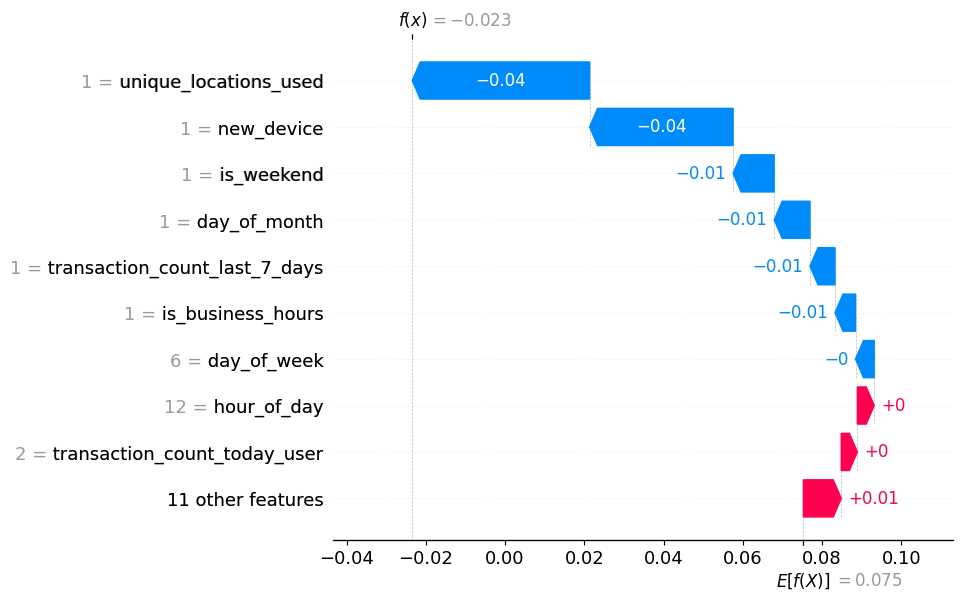

In [41]:
# Plot waterfall plot of an anomaly
shap.plots.waterfall(shap_values[0])

1. **Overall Meaning**
- The plot explains **why this single transaction was scored as anomalous (or not)**.
- The baseline value (on the right: **E[f(X)] = 0.075**) is the **average anomaly score** across all samples.
- The predicted value for this transaction is shown at the top (**f(x) = -0.023**). Since this score is negative, the model leans toward anomaly.

2. **How to Read It**
- Features are listed on the left (e.g., `unique_locations_used`, `new_device`, `is_weekend`).
- Each feature either **pushes the score toward anomaly (blue, negative) or toward normal (red, positive)**.
- The size of the bar shows how much that feature contributed.

3. **Interpretation of this Case**
- Most important anomaly drivers (blue):

    - `unique_locations_used = 1 (–0.04)`: Using a new location strongly pushed the score toward anomaly.
    - `new_device = 1 (–0.04)`: Logging in from a new device also strongly contributed to anomaly.
    - `is_weekend = 1 (–0.01)`: Being a weekend added a smaller anomaly effect.
    - `transaction_count_last_7_days = 1 (–0.01)`: Low transaction history also pushed toward anomaly.

- Features pulling toward normal (red):
    - `amount = 2981.21 (+0.01)`: The transaction amount looks normal compared to history.
    - `hour_of_day = 12 (+0.0)`: Time of day is consistent with normal behavior.
    - `is_business_hours = 1 (+0.0)`: Happening during working hours makes it less suspicious.

For this transaction, the model judged it as somewhat anomalous (score –0.023).

- The **main suspicious signals** were: the user used a new location, a new device, and transacted during a weekend, while also having **low activity history**.

- On the other hand, the **transaction amount**, time of day, and the fact it was during **business hours** helped make it look more normal.

“This transaction was flagged as anomalous mainly because it came from a new device and location, during the weekend, and with limited user history — even though the amount and timing looked normal.”

### Extracting top anomalies

In [42]:
df_encoded['anomaly_score'] = -df_encoded['anomaly_score']

In [43]:
# Get top-N anomalies
N = 10
top_anomalies = df_encoded.nlargest(N, 'anomaly_score')

print("Top anomalies:")
print(top_anomalies)

Top anomalies:
                datetime   user_id  transaction_type     amount currency  \
1962 2025-06-08 14:17:40  user1026                 8  4242.7500      GBP   
385  2025-06-25 07:42:49  user1006                 0   973.8125      GBP   
5471 2025-06-09 06:00:23  user1072                 1   827.5500      GBP   
1796 2025-06-18 07:33:29  user1022                 1  1416.0000      USD   
4971 2025-07-13 09:56:17  user1065                 3    61.2500      GBP   
1186 2025-06-07 11:28:34  user1015                 6  4191.4625      GBP   
3777 2025-06-02 21:58:38  user1047                 8  4924.5400      USD   
4192 2025-06-13 06:04:41  user1053                 8  6139.0250      GBP   
5920 2025-06-21 03:03:12  user1079                 7   428.8460      EUR   
5476 2025-06-18 10:43:43  user1072                 7  1062.4625      GBP   

      location  device  day_of_week  hour_of_day  month  ...  \
1962         2       5            6           14      6  ...   
385          3      

C:\Users\user\AppData\Local\Temp\ipykernel_29384\2249384083.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
2025-08-15 23:36:07,539 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0.
2025-08-15 23:36:07,541 - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\user\\Desktop\\moniepoint\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-08-15 23:36:07,542 - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\user\\Desktop\\moniepoint\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch=

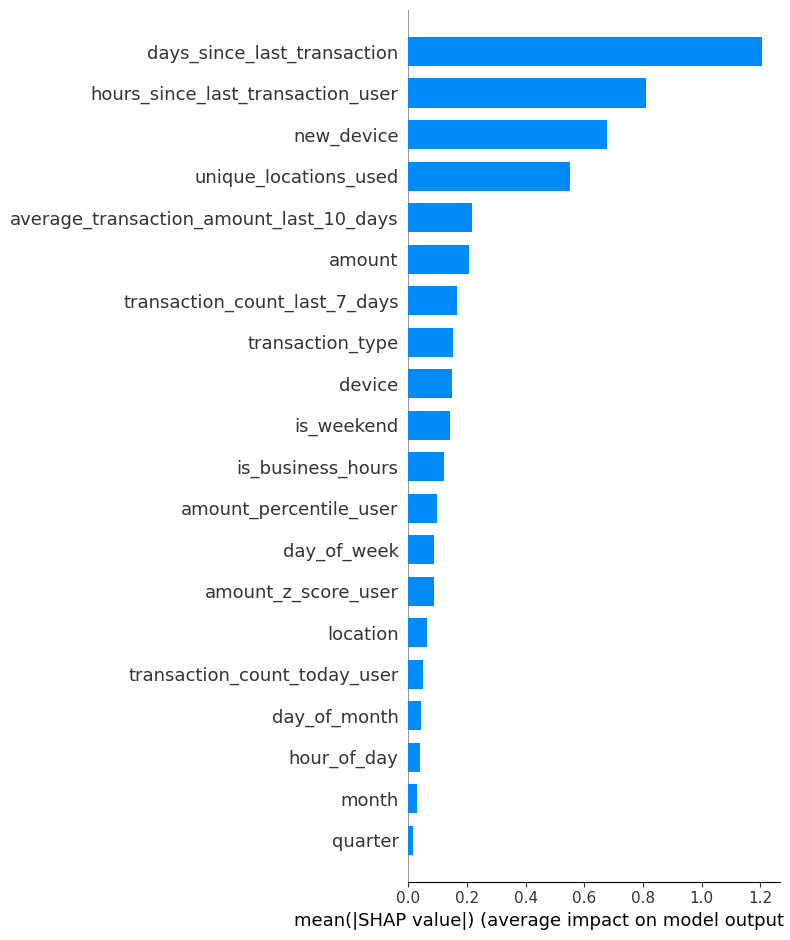

In [44]:
# Drop anomaly columns 
drop_cols = [c for c in ['anomaly_score', 'anomaly_label'] if c in df_encoded.columns]
df_features = df_encoded.drop(columns=drop_cols)

# Keep only numeric columns for SHAP
df_features = df_features.select_dtypes(include=['number'])

# SHAP explainer
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_features)

# Plot SHAP summary for top anomalies
shap.summary_plot(
    shap_values[top_anomalies.index, :],
    df_features.iloc[top_anomalies.index],
    plot_type="bar"
)

C:\Users\user\AppData\Local\Temp\ipykernel_29384\1118137712.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_result[:,0], pca_result[:,1],


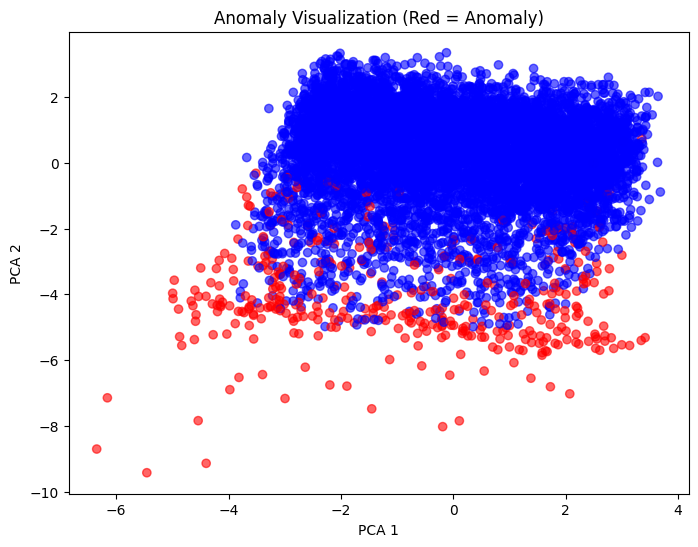

In [49]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2)
pca_result = pca.fit_transform(StandardScaler().fit_transform(df_features))

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1],
            c=df_encoded['anomaly_label'].map({0:'blue', 1:'red'}), alpha=0.6, cmap="coolwarm")
plt.title("Anomaly Visualization (Red = Anomaly)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [ ]:
def evaluate_outlier_classifier(model, data):
    # Get labels
    labels = model.fit_predict(data)

    # Return inliers
    return data[labels == 0]
def evaluate_regressor(inliers):
    X = inliers.drop("price", axis=1)
    y = inliers[['price']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    preds = lr.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)

    return round(rmse, 3)